# Example notebook for aggregating, averaging and other statistical operations

In this notebook we will use the model simulations from the `another_example_with_csv_export.ipynb` notebook where we ran the Harvard FluxNet site. So we don't need to do new simulations here and will not need to use `pysumma`. Instead, we'll use the existing model output to aggregate output over different time periods, will look at some sub-setting of model outputs, and calculate some aggregate statistics. To do this we'll use some built-in functionality from `xarray` and `pandas`.

As before: Make use of the notebooks abilities to document what you are doing, so add text and comments as needed.

## Import modules and set some default settings

I typically start my notebook with an import of all the modules that I will be using anyway. I also use the same aliases every time, to make it easier to follow what I am doing:

In [1]:
%matplotlib inline
#import pysumma as ps # we don't need pysumma here, but you could also just leave it
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import seaborn as sns # a module that adds some plotting capabilities and makes your plots look better
import pandas as pd # an excellent time series package that we'll use to write some csv files

In [2]:
sns.set() # activates some of the default settings from seaborn
# The following settings just set some defaults for the plots
plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['axes.labelsize']  = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.dpi'] = 200

## Reading from file

As said, we can use the model output file we created before. Because NetCDF files have their own metadata, you can simply use `xr.open_dataset()` to open an existing file.

In [3]:
Harvard_summa_file = '/home/jovyan/PLUMBER_data/sites/Harvard/summa_output/Harvard_output_test_timestep.nc'
ds = xr.open_dataset(Harvard_summa_file)

and to get the context, just type

In [4]:
ds

<xarray.Dataset>
Dimensions:                  (gru: 1, hru: 1, ifcSoil: 10, ifcToto: 15, midSoil: 9, midToto: 14, time: 140256)
Coordinates:
  * time                     (time) datetime64[ns] 1994-01-01T00:30:00.000013408 ... 2002-01-01
  * hru                      (hru) int32 1
Dimensions without coordinates: gru, ifcSoil, ifcToto, midSoil, midToto
Data variables:
    pptrate                  (time, hru) float64 ...
    airtemp                  (time, hru) float64 ...
    hruId                    (hru) int32 ...
    basin__SurfaceRunoff     (time, gru) float64 ...
    basin__ColumnOutflow     (time, gru) float64 ...
    basin__AquiferStorage    (time, gru) float64 ...
    basin__AquiferRecharge   (time, gru) float64 ...
    basin__AquiferBaseflow   (time, gru) float64 ...
    basin__AquiferTranspire  (time, gru) float64 ...
    averageInstantRunoff     (time, gru) float64 ...
    averageRoutedRunoff      (time, gru) float64 ...
    nSnow                    (time, hru) int32 ...
    nS

## Aggregating

We'll basically be relying on [aggregation capabilities in pandas](http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling) (called resampling in pandas), which `xarray` uses under the hood.

Let's start with a quick plot of the `scalarLatHeatTotal` for the Harvard site:

/srv/conda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


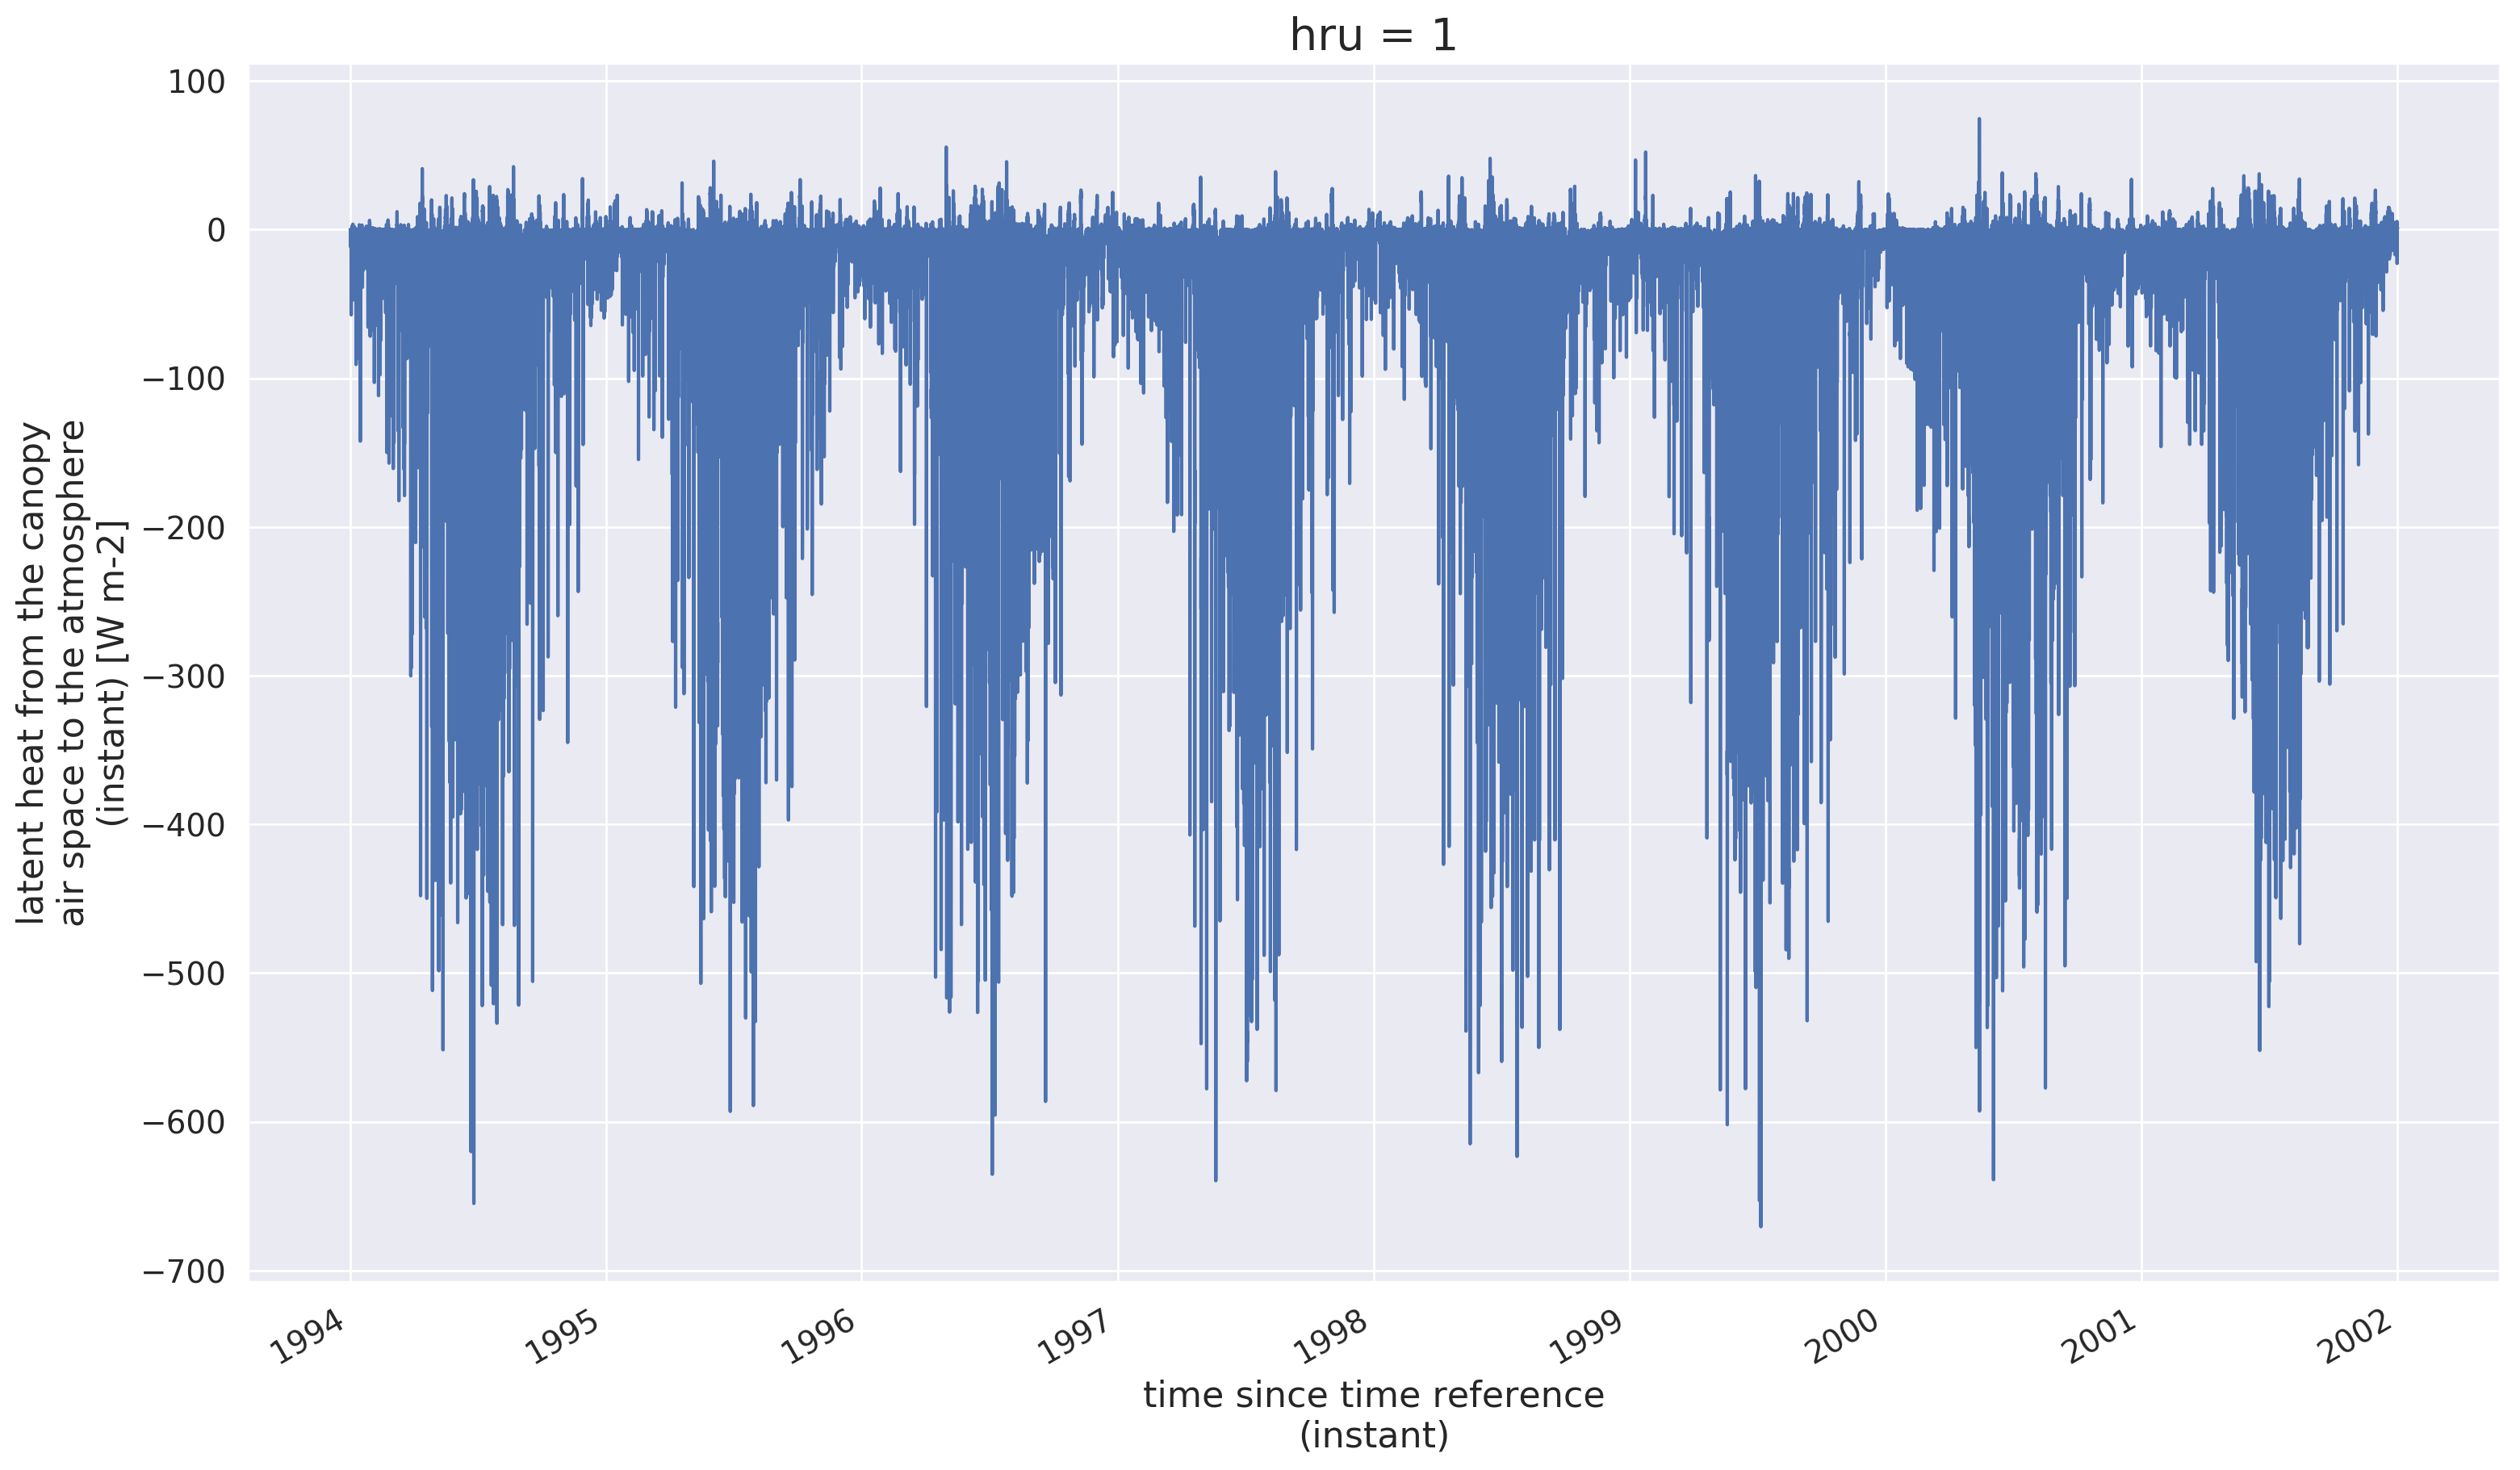

In [5]:
ds.scalarLatHeatTotal.plot()

Note that the values are mostly negative, because of SUMMA's sign convention. Negative in this case means upward or away from the land surface.

The output time interval in the raw simulation is 30 minutes, which results in a really busy plot. It would be nice if we could plot the values aggregated to a coarser interval. **resample()** to the rescue! (Let's also swap the sign while we are doing this).

/srv/conda/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


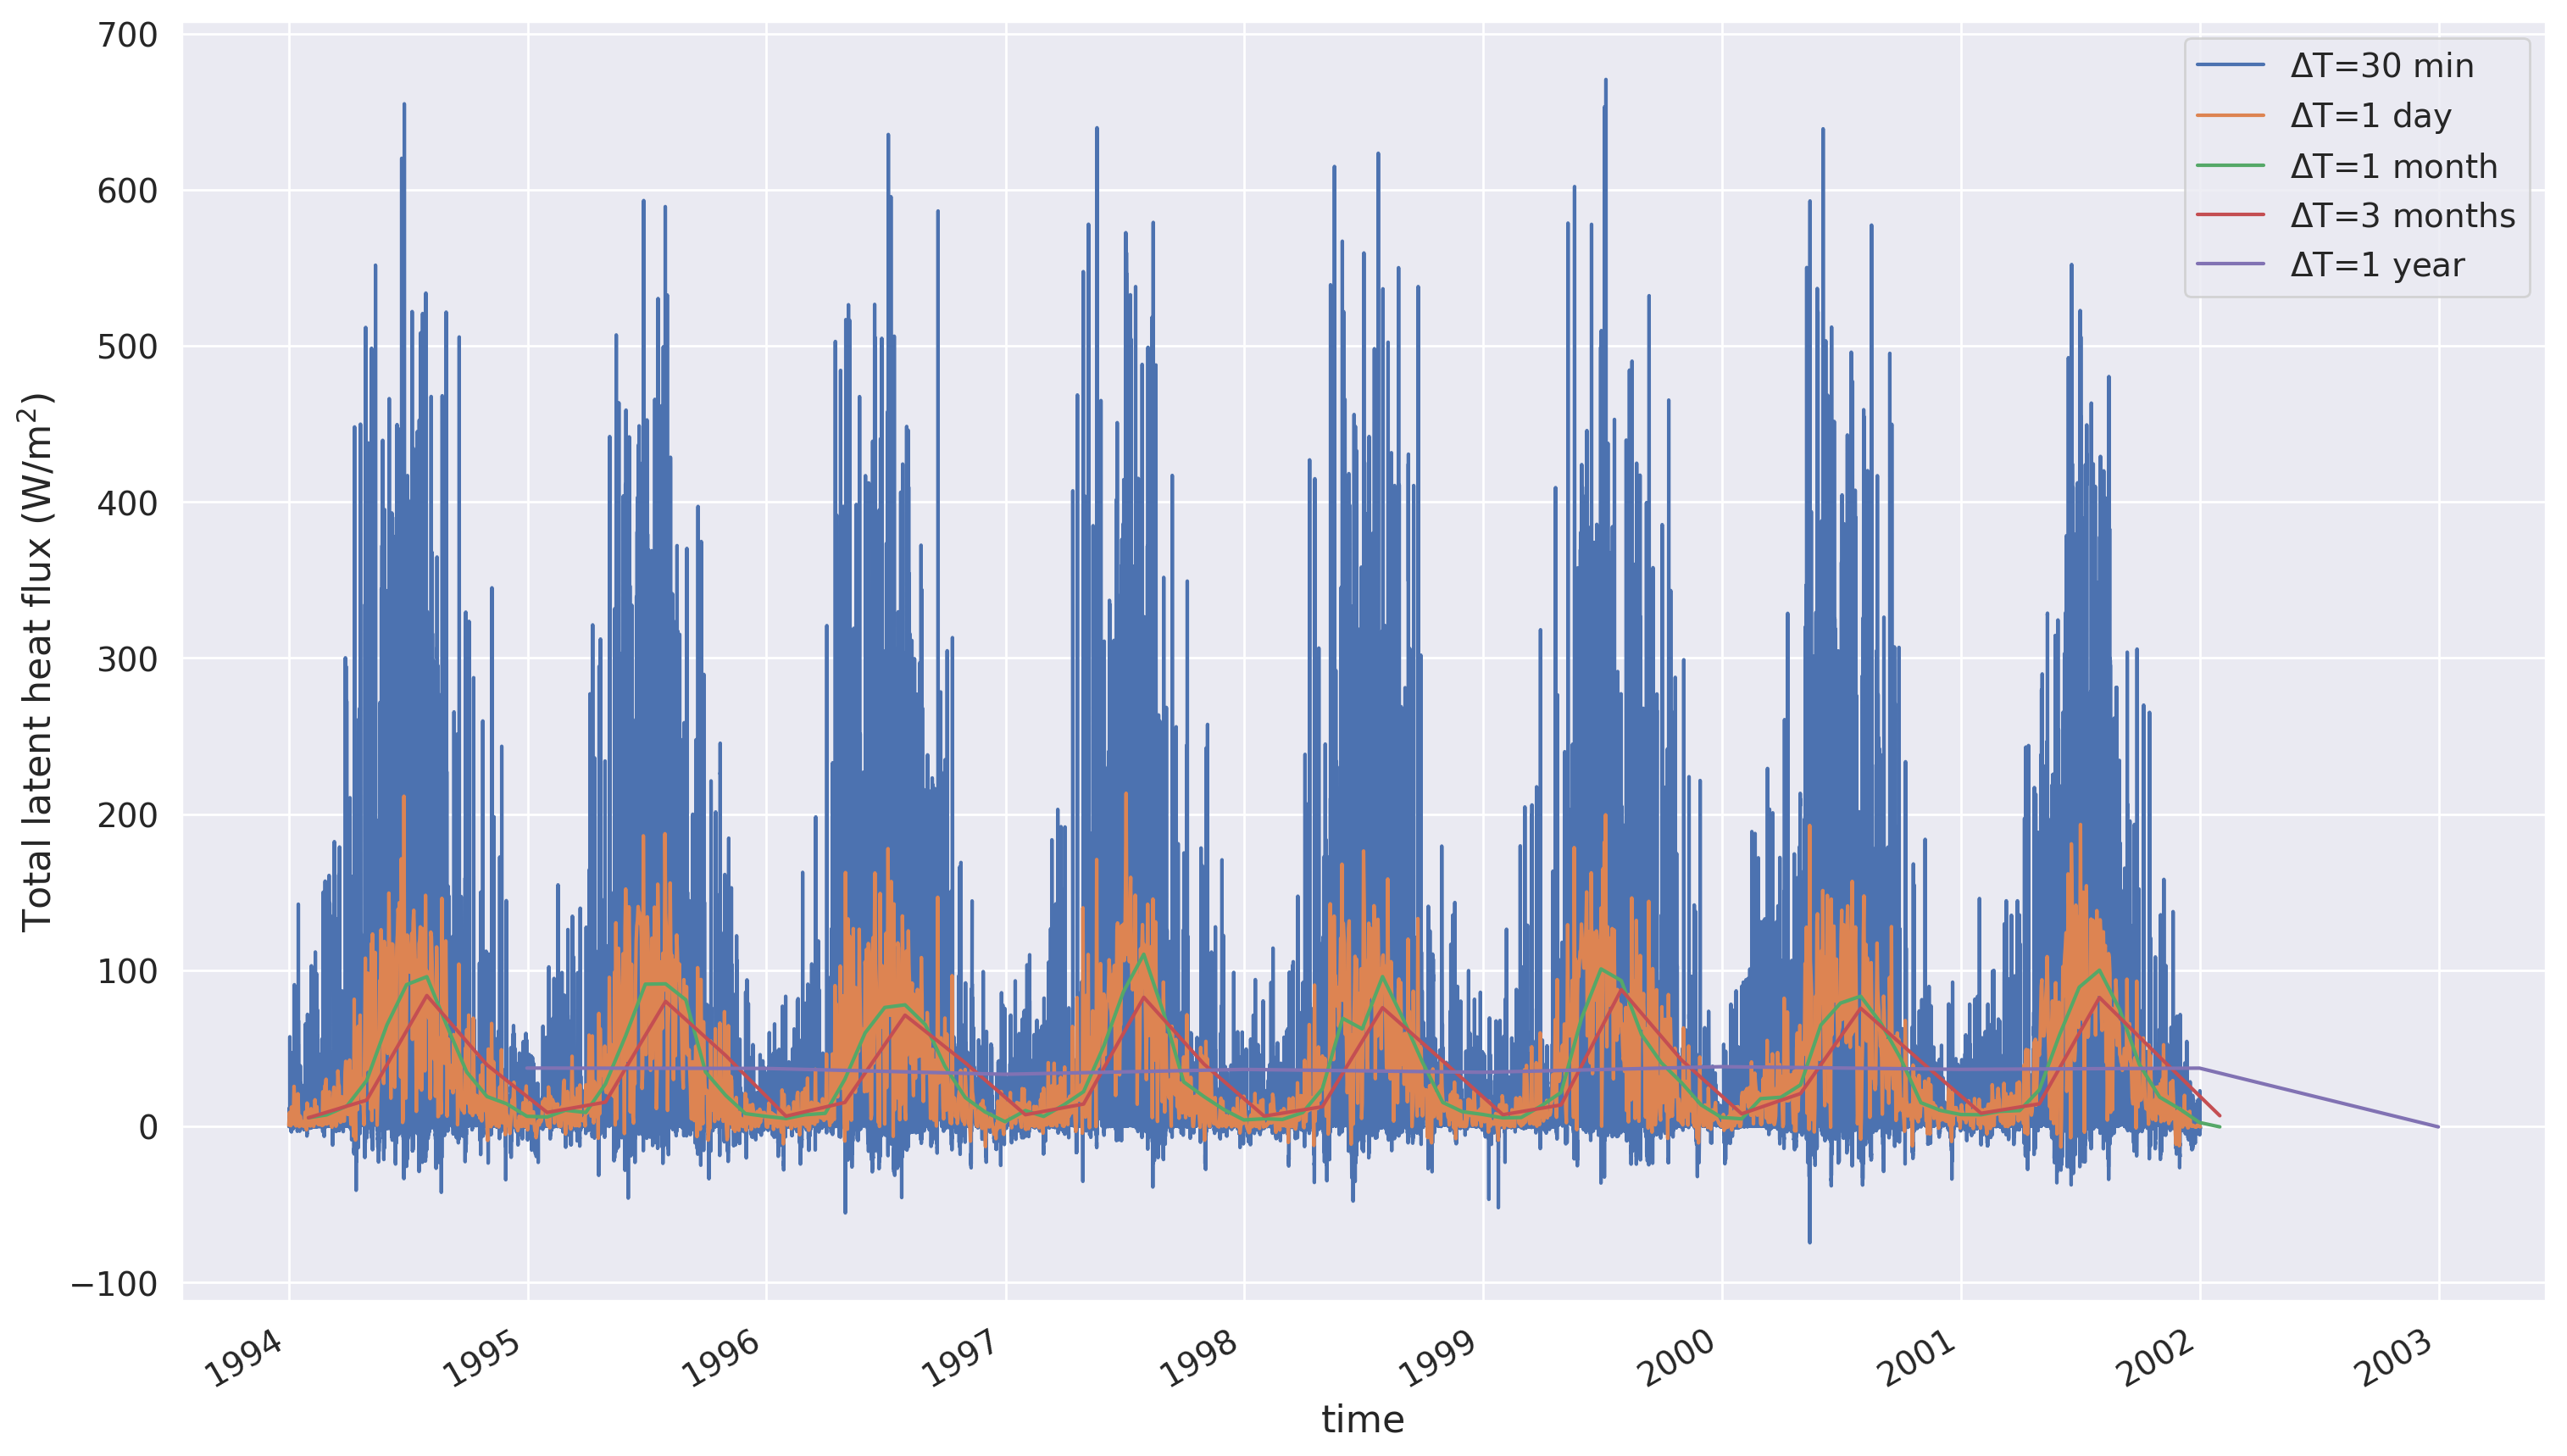

In [6]:
(-ds.scalarLatHeatTotal).plot(label="$\Delta$T=30 min")
(-ds.scalarLatHeatTotal).resample(time='1D').mean().plot(label="$\Delta$T=1 day")
(-ds.scalarLatHeatTotal).resample(time='1M').mean().plot(label="$\Delta$T=1 month")
(-ds.scalarLatHeatTotal).resample(time='3M').mean().plot(label="$\Delta$T=3 months")
(-ds.scalarLatHeatTotal).resample(time='1Y').mean().plot(label="$\Delta$T=1 year")
plt.ylabel("Total latent heat flux (W/m$^2$)")
plt.legend()

As you can see, the aggregation (or resampling) is very straightforward. The resampling happens in two steps. The first step (`resample()`) groups the values into each new interval. The second step applies some statistical operation to the values in each interval. Here we just take the mean (`mean()`), but you can apply many other operations. For example, to make a plot that shows the full range of daily `scalarLatHeatTotal` values by month, you can do something like this

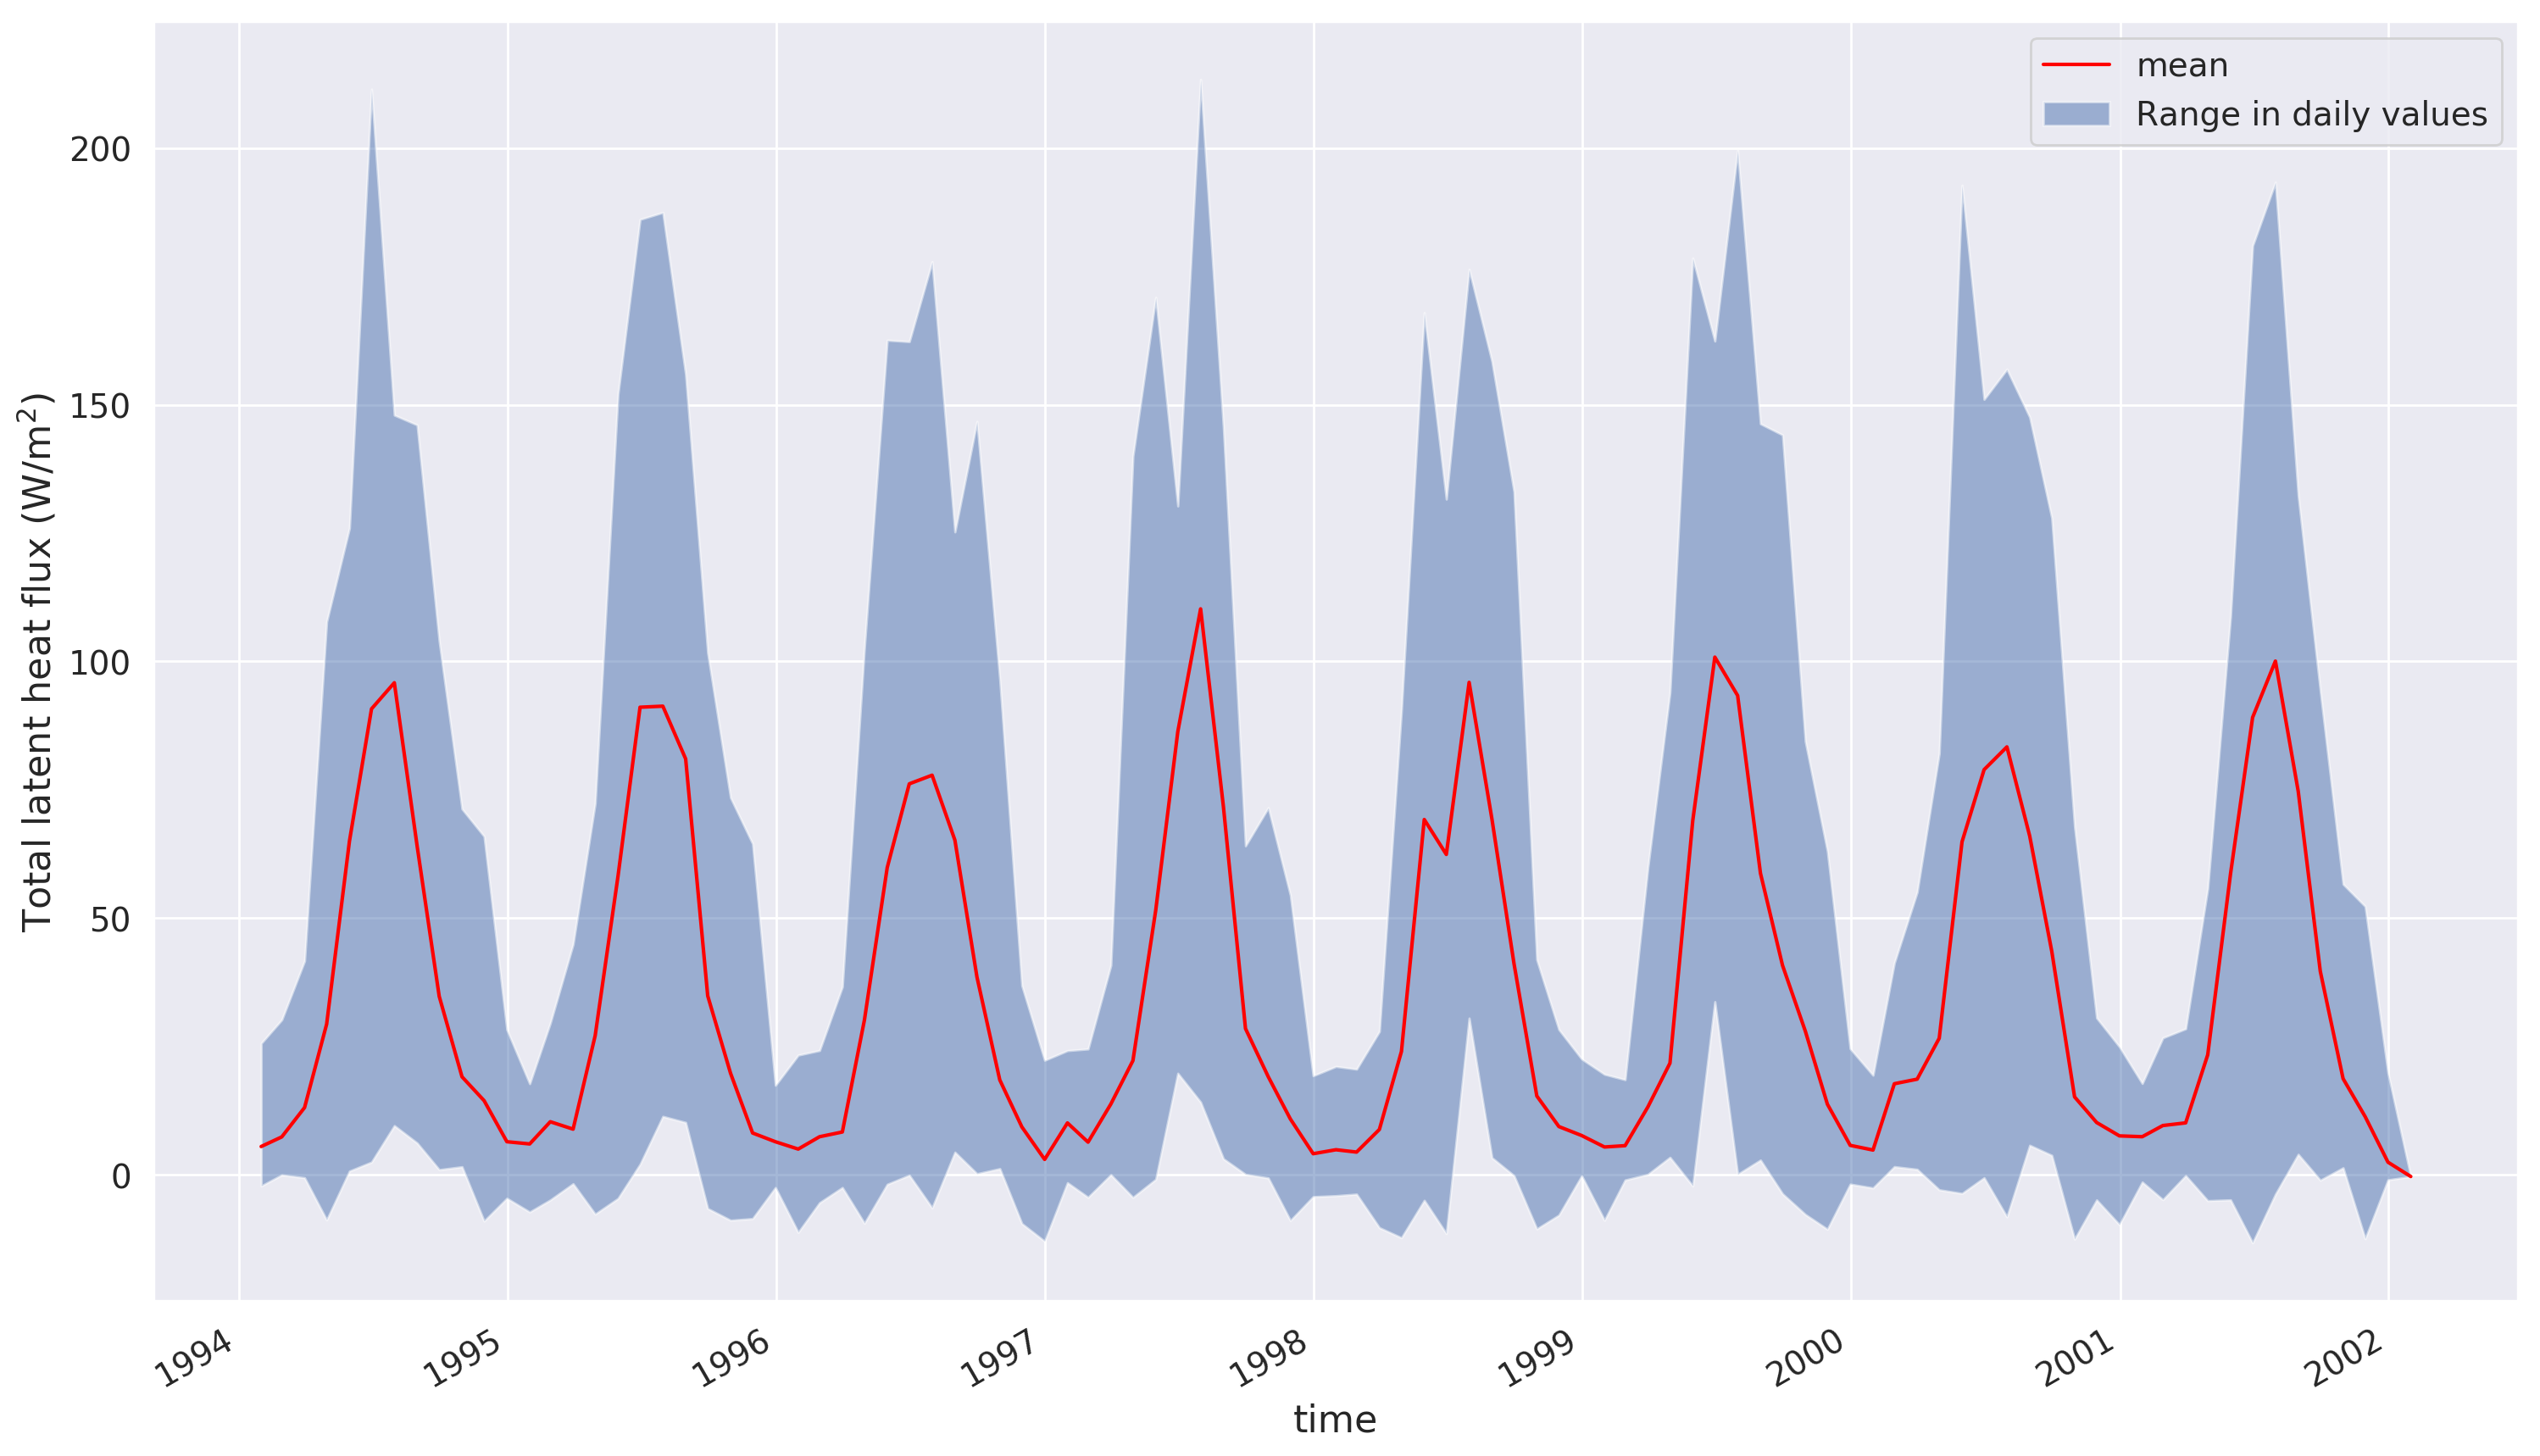

In [7]:
dv_lat_mean = (-ds.scalarLatHeatTotal).resample(time='1D').mean() # resample values to daily means
mv_lat = dv_lat_mean.resample(time='1M') # resample daily values to monthly 
mv_lat.mean().plot(color="red", label="mean") # plot the mean
# now we use fill_between to shade the range between the minimum and maximum daily values in each month
timestamp = mv_lat.min()['time']
plt.fill_between(timestamp.values, mv_lat.min().values, mv_lat.max().values, alpha=0.5, label="Range in daily values")
plt.ylabel("Total latent heat flux (W/m$^2$)")
plt.legend()

One additional thing to note is that the `resample()` command has to assign the aggregated value to a specific time. This varies a bit on what you are aggregating to. The [pandas documentation on resample()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html) states that *The default is ‘left’ for all frequency offsets except for ‘M’, ‘A’, ‘Q’, ‘BM’, ‘BA’, ‘BQ’, and ‘W’ which all have a default of ‘right’*. You can control this with the `label` and `loffset` arguments.

For example, when you look at the original time series, the timestamp for the first time step is

In [8]:
ds.time[0]

<xarray.DataArray 'time' ()>
array('1994-01-01T00:30:00.000013408', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1994-01-01T00:30:00.000013408
Attributes:
    long_name:  time since time reference (instant)

the timestamp for the first value in the daily aggregation is (so the time stamp is the one on the left side of the interval):

In [9]:
dv_lat_mean.time[0]

<xarray.DataArray 'time' ()>
array('1994-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1994-01-01

and aggregating to monthly assigns the timestamp to the right side of the interval.

In [10]:
mv_lat.mean().time[0]

<xarray.DataArray 'time' ()>
array('1994-01-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1994-01-31

If you wanted to change this you could do

In [11]:
mv_lat_left = dv_lat_mean.resample(time='1M', label='left')
mv_lat_left.mean().time[0]

<xarray.DataArray 'time' ()>
array('1993-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1993-12-31

Although you have to be careful with this, because it now assigns the value to the end of the previous month, which could results in unexpected results when you now look at yearly values. You could shift the value forward 1-day by specifying the `loffset`.

In [12]:
mv_lat_left = dv_lat_mean.resample(time='1M', label='left', loffset='1D')
mv_lat_left.mean().time[0]

<xarray.DataArray 'time' ()>
array('1994-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1994-01-01

All this to say - **be careful and check what you are doing**.

To remake the plot we already had and remove the offset

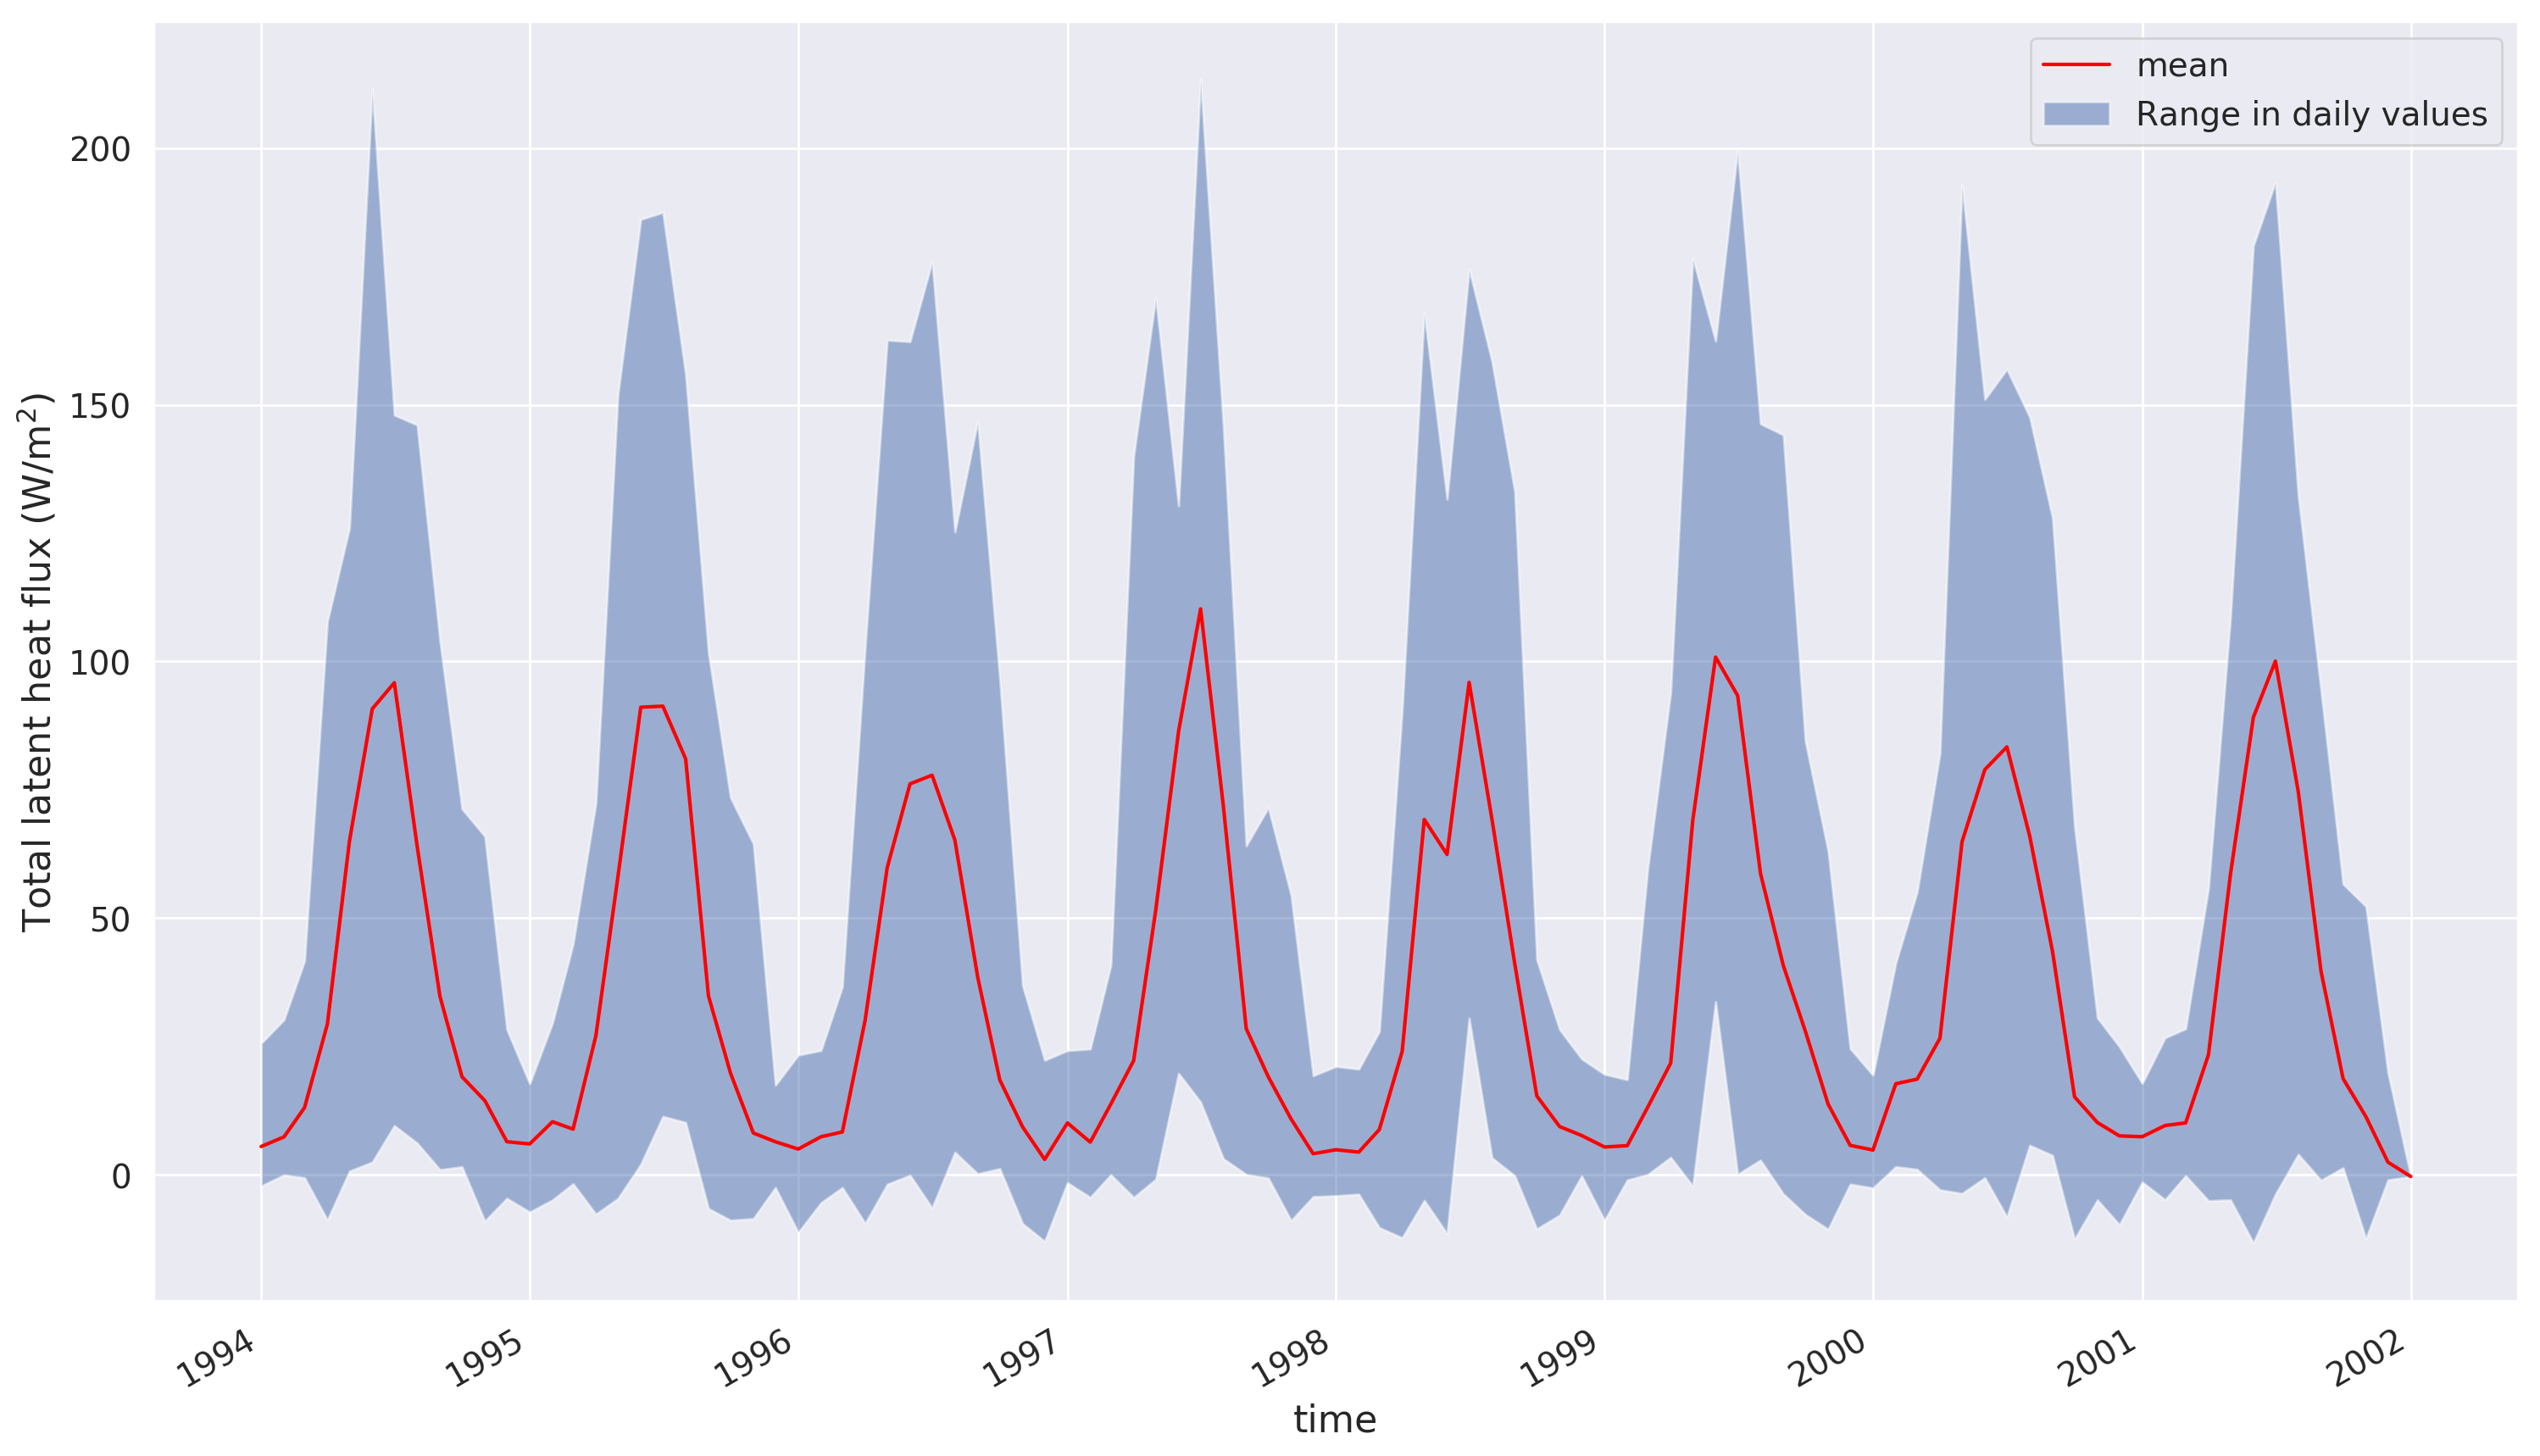

In [13]:
dv_lat_mean = (-ds.scalarLatHeatTotal).resample(time='1D').mean() # resample values to daily means
mv_lat = dv_lat_mean.resample(time='1M', label='left', loffset='1D') # resample daily values to monthly 
mv_lat.mean().plot(color="red", label="mean") # plot the mean
# now we use fill_between to shade the range between the minimum and maximum daily values in each month
timestamp = mv_lat.min()['time']
plt.fill_between(timestamp.values, mv_lat.min().values, mv_lat.max().values, alpha=0.5, label="Range in daily values")
plt.ylabel("Total latent heat flux (W/m$^2$)")
plt.legend()

Note that the last month is now `2002-01-01`, which consists of only a single value (which is why the min, max, and mean values are all the same). So we want to limit the range of the plot (not plot the final value). Which brings us to the next step: *slicing*, *windowing* or subsetting.

## Slicing using dates

Note that there is excellent information available on all these topics in the python, [pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html) and [xarray](http://xarray.pydata.org/en/stable/indexing.html) documentation, so I am only giving some basic examples here that are relevant to handling time series data that are used in earlier notebooks.

One of the nice things for our purpose is that xarray and pandas can interpret dates. So if I only want the information for the year 1998, I can just apply a window. For example:

In [14]:
ds_1998 = ds.loc[dict(time=slice('1998-01-01', '1998-12-31'))]

The first and last values of this slice are

In [15]:
print('First: {}\n'.format(ds_1998.time[0]))
print('Last: {}'.format(ds_1998.time[-1]))

First: <xarray.DataArray 'time' ()>
array('1998-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1998-01-01
Attributes:
    long_name:  time since time reference (instant)

Last: <xarray.DataArray 'time' ()>
array('1998-12-31T23:29:59.999986592', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1998-12-31T23:29:59.999986592
Attributes:
    long_name:  time since time reference (instant)


And repeating our plot for just 1998:

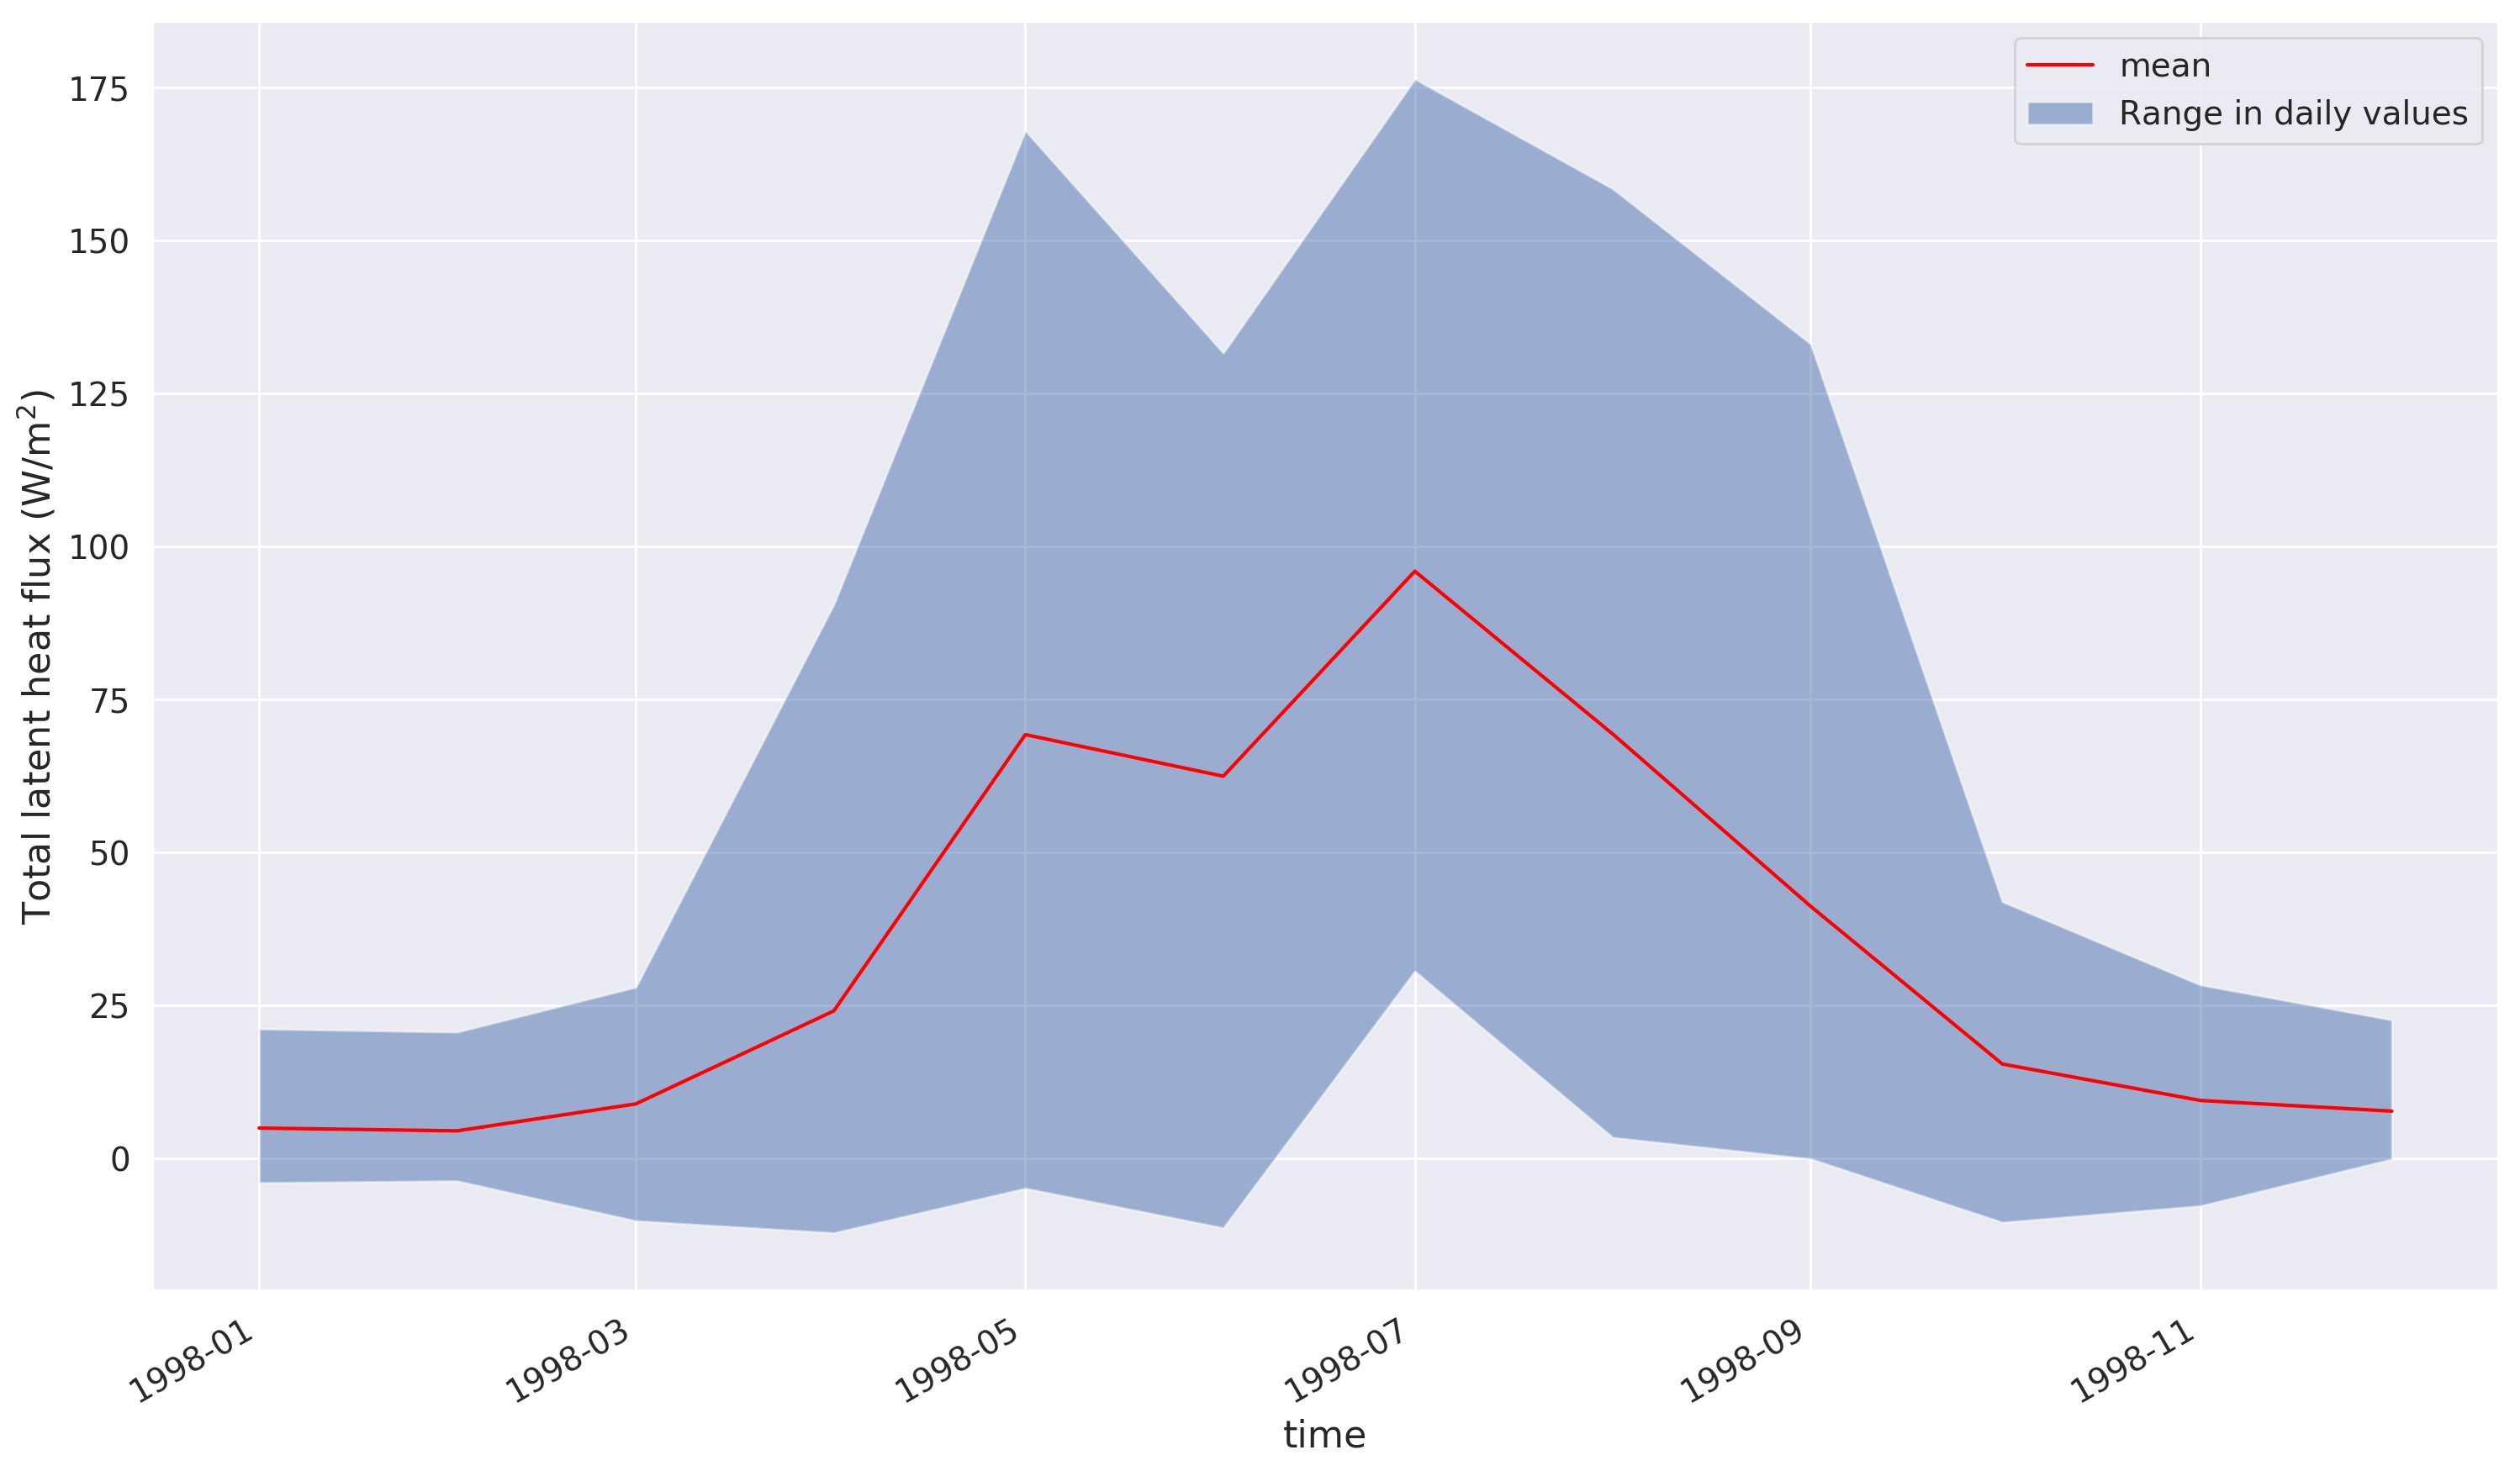

In [16]:
dv_lat_mean = (-ds_1998.scalarLatHeatTotal).resample(time='1D').mean() # resample values to daily means
mv_lat = dv_lat_mean.resample(time='1M', label='left', loffset='1D') # resample daily values to monthly 
mv_lat.mean().plot(color="red", label="mean") # plot the mean
# now we use fill_between to shade the range between the minimum and maximum daily values in each month
timestamp = mv_lat.min()['time']
plt.fill_between(timestamp.values, mv_lat.min().values, mv_lat.max().values, alpha=0.5, label="Range in daily values")
plt.ylabel("Total latent heat flux (W/m$^2$)")
plt.legend()

Of course, you don't always have to make plots. You can just report the values

In [17]:
mv_lat.mean()

<xarray.DataArray 'scalarLatHeatTotal' (time: 12)>
array([ 4.880677,  4.422689,  8.828802, 24.028686, 69.207089, 62.403624,
       95.922588, 69.291199, 41.125663, 15.353523,  9.393295,  7.645899])
Coordinates:
  * time     (time) datetime64[ns] 1998-01-01 1998-02-01 ... 1998-12-01

You can display this in your notebook as a table using some extra python modules:

In [18]:
from IPython.display import display, HTML

display(HTML(mv_lat.mean().to_dataframe().to_html()))

,scalarLatHeatTotal
time,
1998-01-01,4.880677
1998-02-01,4.422689
1998-03-01,8.828802
1998-04-01,24.028686
1998-05-01,69.207089
1998-06-01,62.403624
1998-07-01,95.922588
1998-08-01,69.291199
1998-09-01,41.125663


and of course you can export the subsetted and aggregated data to a csv file (so you could do some of your aggregation here before you send it to another program): 

In [19]:
csv_file = '/home/jovyan/PLUMBER_data/sites/Harvard/summa_output/Harvard_monthly_latent_heat_1998.csv'
mv_lat.mean().to_dataframe().to_csv(csv_file, header=["Total monthly latent heat flux (W/m2)"])

If you want to export your data to csv, it may be easier to organize all the aggregate statistics into one dataframe so everything ends up into a single file. For example:

In [20]:
mv_mean = mv_lat.mean()
mv_mean.name = 'mean'
mv_median = mv_lat.median()
mv_median.name = 'median'
mv_min = mv_lat.min()
mv_min.name = 'min'
mv_max = mv_lat.max()
mv_max.name = 'max'
mv_std = mv_lat.std()
mv_std.name = 'std'

csv_file = '/home/jovyan/PLUMBER_data/sites/Harvard/summa_output/Harvard_monthly_latent_heat_stats_1998.csv'
df = xr.merge([mv_mean, mv_min, mv_max, mv_median, mv_std])
df.to_dataframe().to_csv(csv_file, header=True)

## Aggregation by grouping

I'll showcase one more way of aggregation that uses [panda's](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) and [xarray's](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.groupby.html) `groupby()` functionality, which is very convenient. This functionality is very powerful and generally applicable, but the documentation can be confusing, so I'll provide some example how to `groupby()` based on different time attributes (e.g. month, season, time of day, day of year).

You can access the time axis of your SUMMA output as `ds.time` or `ds['time']`. You can then access a whole slew of additional time characteristics by appending `.dt`, which gives you a `DatetimeAccessor`. You will not be using this directly, but it is the gateway to a lot more functionality. For example, if you time `ds.time.dt.` and hit `<Tab>`, you get a list of all the additional attributes that you have access to. Try it

In [21]:
ds.time.dt. # put cursor after the last period and hit <Tab>

SyntaxError: invalid syntax (<ipython-input-21-31b98e4da3d5>, line 1)

For example, I can group all my values by `weekofyear` and then calculate a statistic across all weeks (e.g. mean) and plot it 

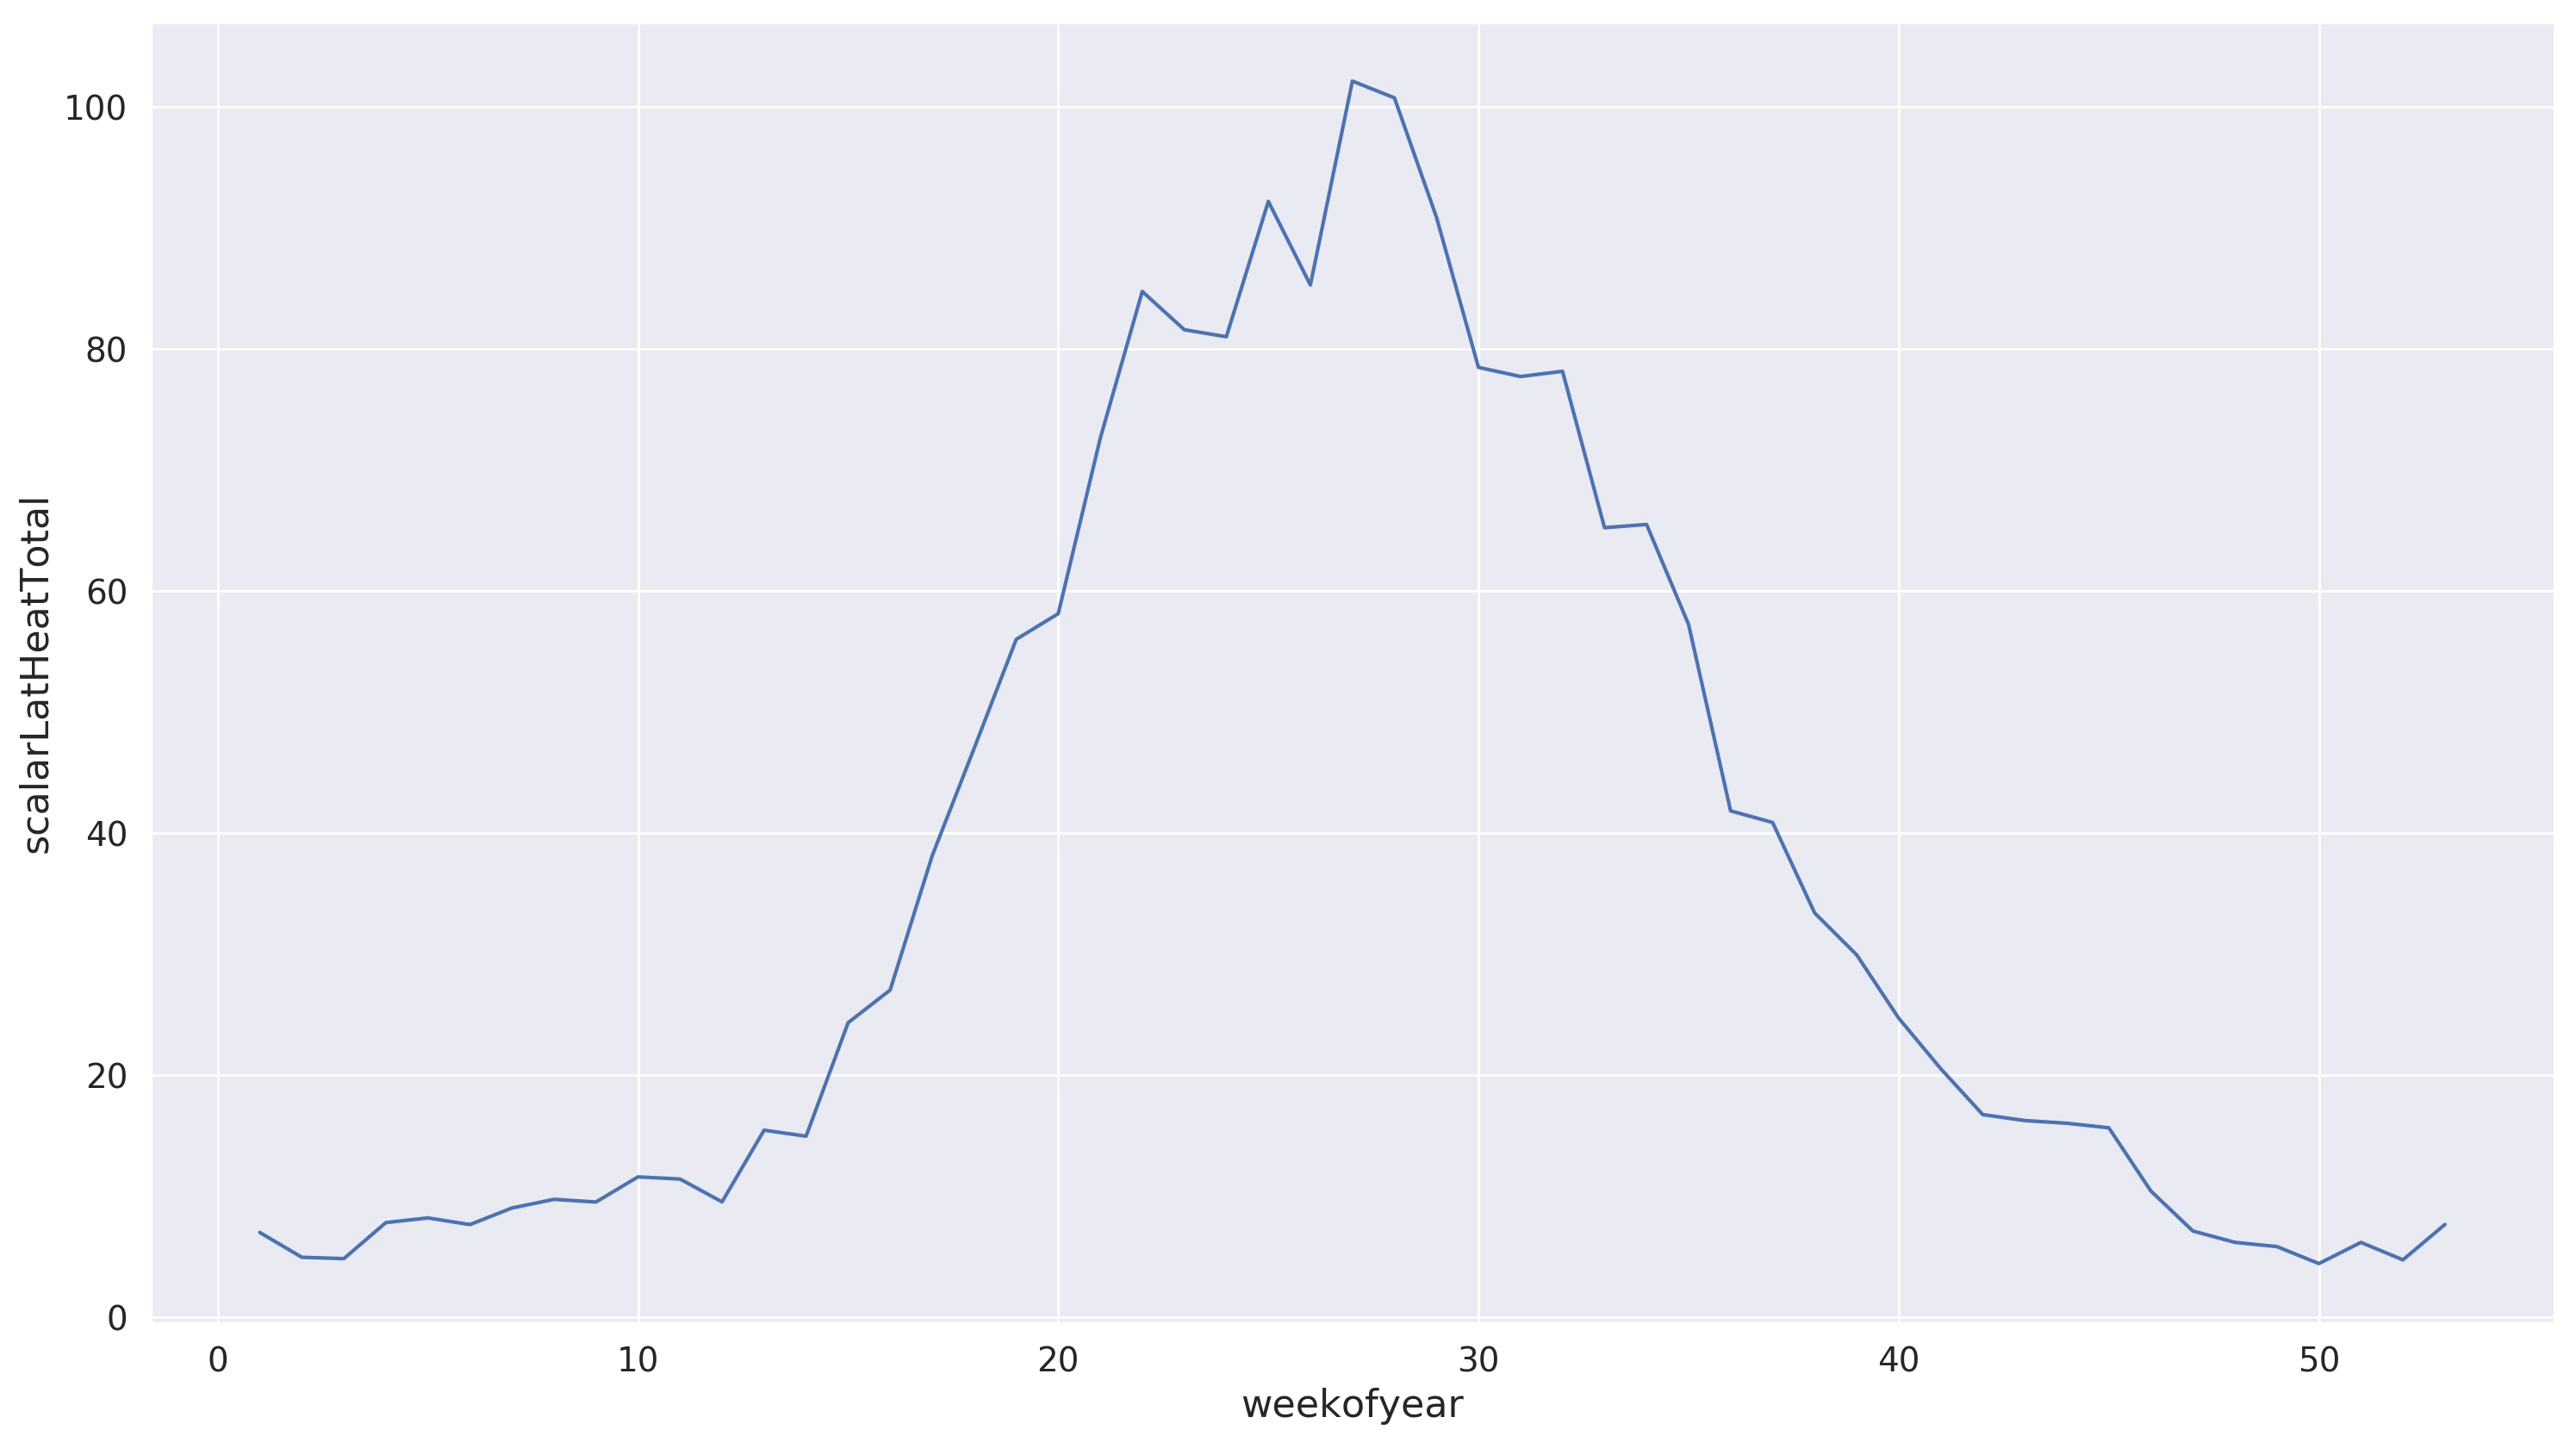

In [22]:
(-ds.scalarLatHeatTotal).groupby(ds.time.dt.weekofyear).mean().plot()

or I can look at the maximum value across all Mondays ([dayofweek is 0](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.dayofweek.html)).

In [23]:
print('Monday average latent heat flux: {:.1f} W/m2'.format((-ds.scalarLatHeatTotal).groupby(ds.time.dt.dayofweek).max()[0].values))

Monday average latent heat flux: 653.1 W/m2


To get the maximum daily mean values by season:

In [28]:
dv = (-ds.scalarLatHeatTotal).resample(time='1D').mean()
dv.groupby(dv.time.dt.season).max()

<xarray.DataArray 'scalarLatHeatTotal' (season: 4)>
array([ 41.271234, 213.375771, 192.764752, 146.756497])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

or to display it more nicely:

In [29]:
display(HTML(dv.groupby(dv.time.dt.season).max().to_dataframe().to_html()))

,scalarLatHeatTotal
season,
DJF,41.271234
JJA,213.375771
MAM,192.764752
SON,146.756497


Putting all the pieces together, let's make boxplots by season of the daily mean values for the total latent heat flux for the period `1996-10-01`-`2001-09-30`.

Text(0.05, 0.95, 'Time period: 1996-10-01 - 2001-09-30')

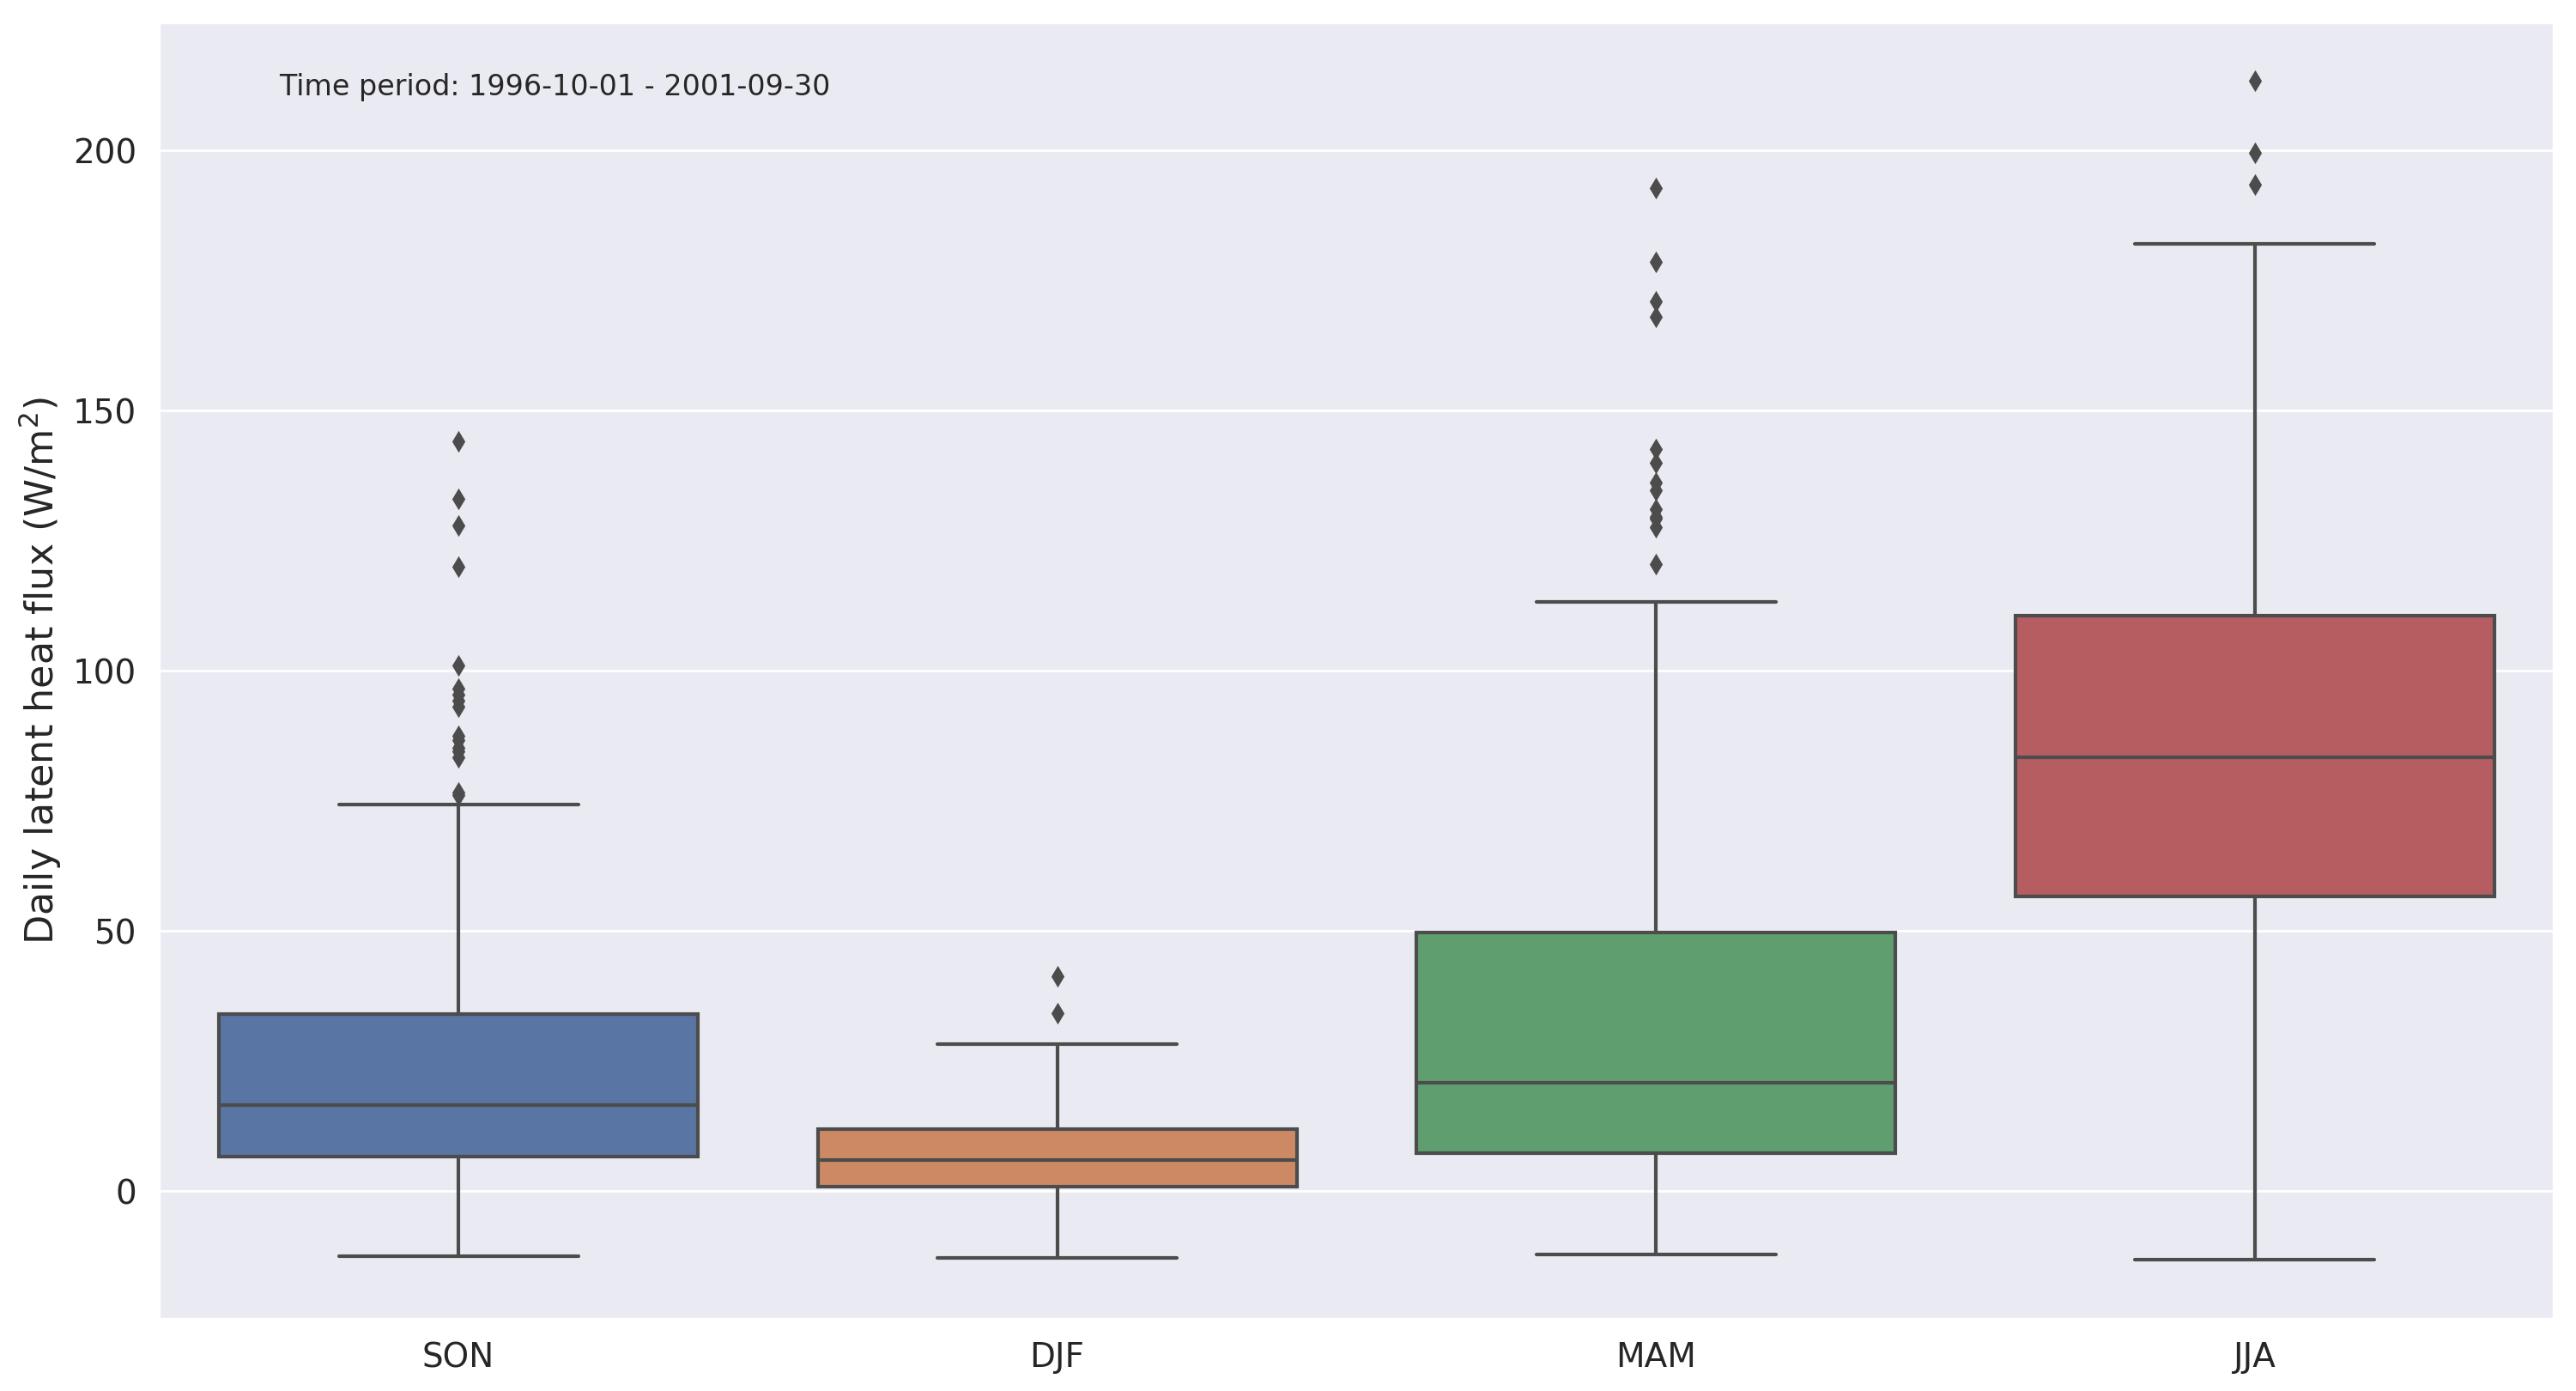

In [30]:
# Subset the data
window = ('1996-10-01', '2001-09-30')
ds_sub = (-ds['scalarLatHeatTotal']).loc[dict(time=slice(*window))]
# resample to daily mean values
dv_sub = ds_sub.resample(time='1D').mean()
# Make a boxplot with the values grouped by season (in this case this happens by the boxplot function)
ax = sns.boxplot(x=dv_sub.time.dt.season.values, y=dv_sub.values)
plt.ylabel("Daily latent heat flux (W/m$^2$)")
plt.text(0.05, 0.95, "Time period: {} - {}".format(window[0], window[1]), 
         horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)